In [1]:
from dotenv import load_dotenv
_ = load_dotenv(dotenv_path='../.env/.env')

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [4]:
class AgentState(TypedDict):
    messages : Annotated[list[AnyMessage], operator.add]

In [13]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [15]:
prompt = """
You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model='gpt-3.5-turbo')
abot = Agent(model, [tool], system = prompt)

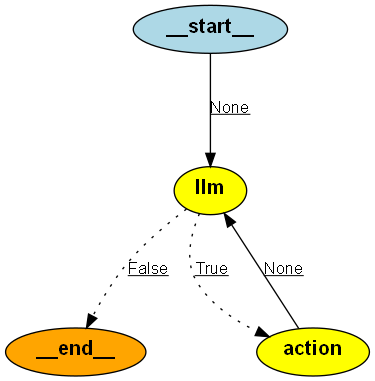

In [16]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [17]:
messages = [HumanMessage(content='What is the weather in SF?')]
result = abot.graph.invoke({'messages': messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_cog45QbvK9Albk3XJy4gbcJP'}
Back to the model!


In [18]:
result

{'messages': [HumanMessage(content='What is the weather in SF?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cog45QbvK9Albk3XJy4gbcJP', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 154, 'total_tokens': 176}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3f8ebc22-72a7-4367-9273-a3a82263c6ff-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_cog45QbvK9Albk3XJy4gbcJP'}], usage_metadata={'input_tokens': 154, 'output_tokens': 22, 'total_tokens': 176}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\':

In [19]:
result['messages'][-1].content

'The current weather in San Francisco is sunny with a temperature of 70.0°F (21.1°C). The wind speed is 4.3 mph (6.8 kph) coming from the southwest direction. The humidity is at 66%, and there is no precipitation at the moment.'

In [21]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-3.5-turbo")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_Ug5q1lKq27wsCJGYdMNrXxZ1'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': "state where Super Bowl 2024 winner's headquarters located"}, 'id': 'call_zkxX3QWT20PRnVncBq2GNmO7'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP'}, 'id': 'call_ffwwO2AfZkgVVkc4rWyxAoO8'}
Back to the model!


In [22]:
print(result['messages'][-1].content)

The GDP of Missouri in 2023 was $344.12 billion.


In [23]:
result['messages']

[HumanMessage(content='Who won the super bowl in 2024? In what state is the winning team headquarters located? What is the GDP of that state? Answer each question.'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ug5q1lKq27wsCJGYdMNrXxZ1', 'function': {'arguments': '{"query": "Super Bowl 2024 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_zkxX3QWT20PRnVncBq2GNmO7', 'function': {'arguments': '{"query": "state where Super Bowl 2024 winner\'s headquarters located"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 179, 'total_tokens': 245}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-10a32891-9ade-47ee-89ad-db38d22ea4de-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_Ug5q1lKq27wsCJGYdMNrXxZ1'}, {'nam